# Siamese Neural Networks for One-shot Image Recognition
Atividade de deep learning baseada no tutorial

https://www.youtube.com/watch?v=LKispFFQ5GU
por Nicholas Renotte

# 1. Configuração inicial

## 1.1 Instalando dependências

In [2]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Importando as dependências

In [3]:
# Importando as dependências padrão
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Importando as dependências do tensorflow - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Configurando GPU Growth

In [5]:
# Evita erros OOM configurando consumo de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Criação das estruturas de pasta

In [8]:
# Configurando os diretórios
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Criando os diretórios
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

A Parte 1, trata-se apenas das configurações iniciais, importação das bibliotecas mais importantes.

# 2. Coleta as imagens positivas e âncoras (entradas)

## 2.1 Descomprimindo o arquivo baixado de rostos com rótulos

In [ ]:
# http://vis-www.cs.umass.edu/lfw/
# Fazer download e jogar na raiz do projeto

In [10]:
# Descompacte os rotos rotulados do Tar GZ no conjunto de dados
!tar -xf lfw.tgz

In [11]:
# Movendo as imagens do lfw para data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Coleta as imagens positivas e âncoras (input)

In [12]:
# Importa a biblioteca uuid para gerar nomes de imagens únicos
import uuid

In [13]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\c593476c-725e-11ed-9b95-5ccd5bfa1b4d.jpg'

In [14]:
# Conecta com a webcam cv2.VideoCapture(X) onde X é o dispositivo
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Corta o frame da câmera para 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Coleta âncoras
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # cria um caminho único
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Grava as imagens positivas
        cv2.imwrite(imgname, frame)
    
    # Mostra a janela de captura
    cv2.imshow('Image Collection', frame)
    
    # apertar q para sair
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# devolve o uso da câmera
cap.release()
# fecha a caixa de captura
cv2.destroyAllWindows()

Até esse ponto, foram realizados duas etapas principais 1) Baixar um conjunto de dados de outras pessoas 2) realizar a captura via webcam

# 3. Carrega e pré processa imagens

## 3.1 Cria variáveis para as pastas

In [18]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [19]:
dir_test = anchor.as_numpy_iterator()

In [20]:
print(dir_test.next())

b'data\\anchor\\fe3ff72c-725e-11ed-9589-5ccd5bfa1b4d.jpg'


## 3.2 Pré processamento - Redimensionamento

In [21]:
def preprocess(file_path):
    
    # Lê a imagem de um caminho
    byte_img = tf.io.read_file(file_path)
    # carrega
    img = tf.io.decode_jpeg(byte_img)
    
    # redimensiona imagem para 100x100x3
    img = tf.image.resize(img, (100,100))
    # Muda a escala da imagem para que fique entre 0 e 1
    img = img / 255.0

    # Returna a imagem
    return img

In [22]:
img = preprocess('data\\anchor\\fe3ff72c-725e-11ed-9589-5ccd5bfa1b4d.jpg')

In [23]:
img.numpy().max()

0.94534314

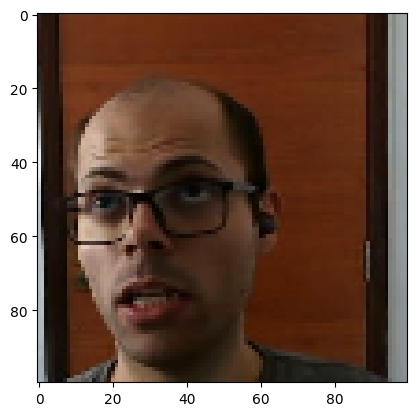

In [24]:
plt.imshow(img)

## 3.3 Cria um conjunto de dados rotulados

In [25]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [26]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [27]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [28]:
samples = data.as_numpy_iterator()

In [29]:
exampple = samples.next()

In [30]:
exampple

(b'data\\anchor\\ff589928-725e-11ed-a06d-5ccd5bfa1b4d.jpg',
 b'data\\positive\\1e6e6eaa-725f-11ed-8f9f-5ccd5bfa1b4d.jpg',
 1.0)

## 3.4 Compila a partição de treino e teste

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [32]:
res = preprocess_twin(*exampple)

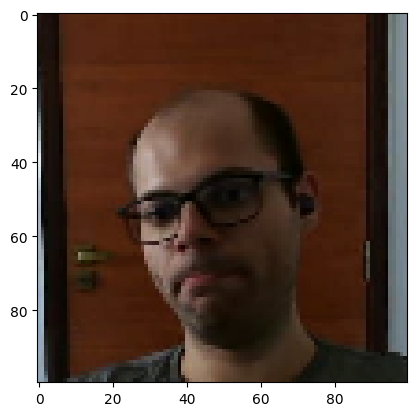

In [37]:
plt.imshow(res[1])

In [39]:
res[2]

1.0

In [40]:
# Compila dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [41]:
# Partição de treino
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [42]:
# Partição de teste
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Até esse ponto, foram carregadas as imagens para o tensorflow dataloader e criado as labels para o dataset

# 4. Modelo

## 4.1 Compilando a Embedding Layer

In [43]:
inp = Input(shape=(100,100,3), name='input_image')

In [44]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [45]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [46]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [47]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [48]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [49]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [50]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [51]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [52]:
embedding = make_embedding()

In [53]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Compilando a camada do L1

In [54]:
# classe que calcula o L1
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Cálculo de similaridade
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [55]:
l1 = L1Dist()

## 4.3 Cria o modelo

In [58]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [59]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [60]:
siamese_layer = L1Dist()

In [61]:
distances = siamese_layer(inp_embedding, val_embedding)

In [62]:
classifier = Dense(1, activation='sigmoid')(distances)

In [63]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [64]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [65]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [66]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [67]:
siamese_model = make_siamese_model()

In [68]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

Capítulo 4 é responsável pela criação das funções do modelo, bem como o fluxo das camadas.

# 5. Treinamento

## 5.1 Configuração da função de perda e otimizador

In [69]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [70]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Criando Checkpoints

In [71]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Compilando treino e funçao do passo

In [72]:
test_batch = train_data.as_numpy_iterator()

In [73]:
batch_1 = test_batch.next()

In [74]:
X = batch_1[:2]

In [75]:
y = batch_1[2]

In [76]:
y

array([1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
      dtype=float32)

In [77]:
tf.losses.BinaryCrossentropy??

In [78]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

## 5.4 Construindo o loop de treinamento

In [79]:
# Importar as bibliotecas para métricas
from tensorflow.keras.metrics import Precision, Recall

In [80]:
def train(data, EPOCHS):
    # loop nas epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # criando os objetos de métricas
        r = Recall()
        p = Precision()
        
        # Loop em cada pacote
        for idx, batch in enumerate(data):
            # roda o passo do treino aqui
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Salva checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Treinando o modelo (Atenção: Aqui pode demorar algumas horas)

In [81]:
EPOCHS = 50

In [82]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 335s 12s/step
0.08357145 0.6255924 1.0

 Epoch 2/50
27/27 [==============================] - 370s 14s/step
0.05214345 0.96744186 1.0

 Epoch 3/50
27/27 [==============================] - 372s 14s/step
0.0013041433 0.9908257 1.0

 Epoch 4/50
27/27 [==============================] - 370s 14s/step
0.005126998 1.0 1.0

 Epoch 5/50
27/27 [==============================] - 433s 16s/step
0.0012825088 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 355s 13s/step
0.0030989938 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 453s 17s/step
0.0002672168 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 370s 14s/step
0.00032295313 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 407s 15s/step
0.0001574345 1.0 1.0

 Epoch 10/50
27/27 [=========

Capítulo 5 é marcado pela criação do modelo, calibração dos parâmetros e geração do arquivo h5

# 6. Validação do modelo

## 6.1 Importando as Métricas

In [83]:
# Importando métricas de cálculo
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Fazendo predições

In [84]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [85]:
y_hat = siamese_model.predict([test_input, test_val])

In [86]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]

In [87]:
y_true

array([1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculando métricas

In [88]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [89]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [90]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


## 6.4 Visualizando resultados

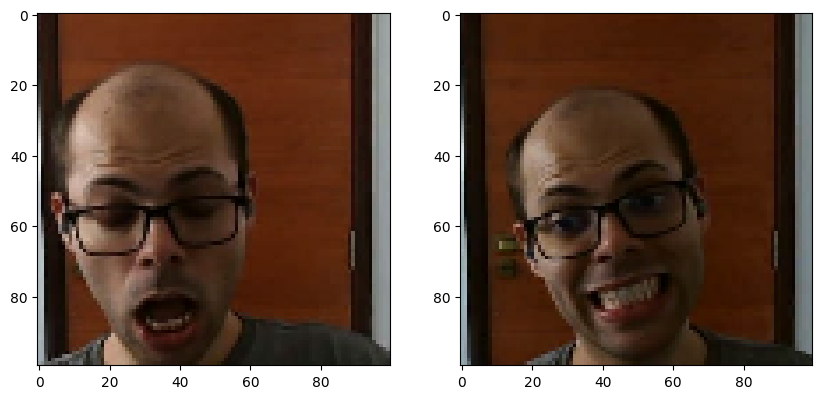

In [93]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

No capítulo 6, podemos verificar se o modelo está adequado, ou se precisa voltar para ajustar. Nesse caso, o modelo sim está adequado.

# 7. Salvando o modelo

In [94]:
# Salva o modelo
siamese_model.save('siamesemodel.h5')

In [95]:
L1Dist

__main__.L1Dist

In [98]:
# Recarrega o modelo
siamese_model = tf.keras.models.load_model('siamesemodel.h5',
                                           custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [99]:
# Faz predições com o modelo carregado
siamese_model.predict([test_input, test_val])

array([[9.9998951e-01],
       [1.0000000e+00],
       [3.4826397e-09],
       [9.9999976e-01]], dtype=float32)

In [100]:
# Visualiza resumo do modelo
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

No capítulo 7 o arquivo é gerado para ser usado em outras aplicações. Além disso, é feita uma verificação se o arquivo foi gerado corretamente.

# 8. Teste em tempo real

## 8.1 Função de verificação

In [110]:
os.listdir(os.path.join('application_data', 'verification_images'))

['1c797709-725f-11ed-a47c-5ccd5bfa1b4d.jpg',
 '1caf4f26-725f-11ed-a8a9-5ccd5bfa1b4d.jpg',
 '1ccf151c-725f-11ed-9310-5ccd5bfa1b4d.jpg',
 '1cf1615f-725f-11ed-a520-5ccd5bfa1b4d.jpg',
 '1d24a974-725f-11ed-86b6-5ccd5bfa1b4d.jpg',
 '1d3827dd-725f-11ed-89eb-5ccd5bfa1b4d.jpg',
 '1e5389e6-725f-11ed-8725-5ccd5bfa1b4d.jpg',
 '2a8ac7ca-725f-11ed-b26f-5ccd5bfa1b4d.jpg',
 '2a998675-725f-11ed-b6a9-5ccd5bfa1b4d.jpg',
 '3204cdb8-725f-11ed-93fe-5ccd5bfa1b4d.jpg',
 '32210541-725f-11ed-8256-5ccd5bfa1b4d.jpg',
 '35519712-725f-11ed-a6d0-5ccd5bfa1b4d.jpg',
 '357415f0-725f-11ed-a203-5ccd5bfa1b4d.jpg',
 '36682096-725f-11ed-84c2-5ccd5bfa1b4d.jpg',
 '41cd5d99-725f-11ed-84c5-5ccd5bfa1b4d.jpg',
 '41e5b0de-725f-11ed-a86b-5ccd5bfa1b4d.jpg',
 '41f6dd9a-725f-11ed-8116-5ccd5bfa1b4d.jpg',
 '42346b23-725f-11ed-bd87-5ccd5bfa1b4d.jpg',
 '42652a7b-725f-11ed-b117-5ccd5bfa1b4d.jpg',
 '427801d5-725f-11ed-91d8-5ccd5bfa1b4d.jpg',
 '42957585-725f-11ed-82b8-5ccd5bfa1b4d.jpg',
 '4373a564-725f-11ed-af41-5ccd5bfa1b4d.jpg',
 '4423a559

In [111]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [112]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\1c797709-725f-11ed-a47c-5ccd5bfa1b4d.jpg
application_data\verification_images\1caf4f26-725f-11ed-a8a9-5ccd5bfa1b4d.jpg
application_data\verification_images\1ccf151c-725f-11ed-9310-5ccd5bfa1b4d.jpg
application_data\verification_images\1cf1615f-725f-11ed-a520-5ccd5bfa1b4d.jpg
application_data\verification_images\1d24a974-725f-11ed-86b6-5ccd5bfa1b4d.jpg
application_data\verification_images\1d3827dd-725f-11ed-89eb-5ccd5bfa1b4d.jpg
application_data\verification_images\1e5389e6-725f-11ed-8725-5ccd5bfa1b4d.jpg
application_data\verification_images\2a8ac7ca-725f-11ed-b26f-5ccd5bfa1b4d.jpg
application_data\verification_images\2a998675-725f-11ed-b6a9-5ccd5bfa1b4d.jpg
application_data\verification_images\3204cdb8-725f-11ed-93fe-5ccd5bfa1b4d.jpg
application_data\verification_images\32210541-725f-11ed-8256-5ccd5bfa1b4d.jpg
application_data\verification_images\35519712-725f-11ed-a6d0-5ccd5bfa1b4d.jpg
application_data\verification_images\357415f0-725f-11ed-a203-5cc

In [113]:
def verify(model, detection_threshold, verification_threshold):

    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # faz predições
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    detection = np.sum(np.array(results) > detection_threshold)

    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Verificação em tempo real

In [116]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # dispara verificação
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # roda a verificação
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
False


Por fim, no capítulo 8 é verificado em tempo real se o modelo consegue predizer adequadamente.